In [1]:
from pathlib import Path

import math
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix

import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import os


from dmba import regressionSummary, classificationSummary,gainsChart, liftChart
from dmba import liftChart, gainsChart
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from IPython.display import Image  
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.tree import export_graphviz
from six import StringIO 
import pydotplus
import graphviz
from sklearn import metrics



In [2]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [3]:
!pip install graphviz
!pip install pydotplus

In [2]:
train_df = pd.read_csv('FlightDelays.csv')
train_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


In [3]:
train_df.to_csv('FlightDelaysTrainingData.csv',index= False)
train_df.to_csv('FlightDelaysExploration.csv',index= False)

## Dimension Reduction 

In [4]:
columns = ['CRS_DEP_TIME', 'DEP_TIME','DAY_WEEK', 'DISTANCE','Weather']


df_Predictors = pd.get_dummies(train_df[columns], drop_first=True)

In [5]:
df_Predictors.head()
df_Predictors.shape

(2201, 5)

In [6]:
norm_df = (df_Predictors - df_Predictors.mean()) / df_Predictors.std()
print(norm_df)

      CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE   Weather
0         0.191962  0.193691  0.049656 -2.092950 -0.121436
1         0.619513  0.611805  0.049656  0.084748 -0.121436
2        -0.293366 -0.280925  0.049656  1.286237 -0.121436
3         0.792844  0.767751  0.049656  1.286237 -0.121436
4        -0.769450 -0.755541  0.049656  1.286237 -0.121436
...            ...       ...       ...       ...       ...
2196     -1.680017 -1.639232  1.100546 -0.966554 -0.121436
2197      0.758178  0.641186  1.100546  0.084748 -0.121436
2198      0.527069  0.426479  1.100546 -0.966554 -0.121436
2199     -0.029902  0.076167  1.100546 -0.966554 -0.121436
2200      0.827510  0.828773  1.100546 -0.966554 -0.121436

[2201 rows x 5 columns]


<AxesSubplot:>

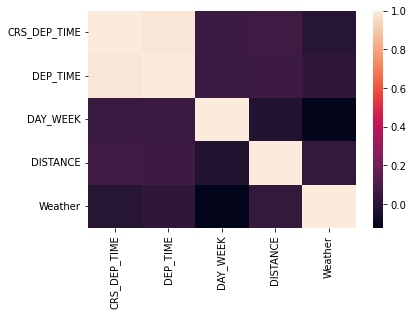

In [7]:
corr = norm_df.corr()
sns.heatmap(corr)

<AxesSubplot:>

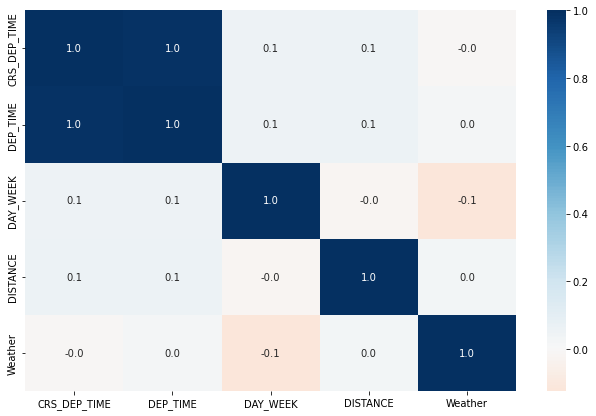

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

## Data Exploration 

In [9]:
data_exploration = pd.read_csv('FlightDelaysExploration.csv')
data_exploration.describe()

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,1371.938664,1369.298955,211.871422,3815.086324,0.014539,3.905498,16.024989
std,432.697149,442.462754,13.316815,2409.750224,0.119725,1.903149,8.677390
min,600.000000,10.000000,169.000000,746.000000,0.000000,1.000000,1.000000
25%,1000.000000,1004.000000,213.000000,2156.000000,0.000000,2.000000,8.000000
50%,1455.000000,1450.000000,214.000000,2385.000000,0.000000,4.000000,16.000000
75%,1710.000000,1709.000000,214.000000,6155.000000,0.000000,5.000000,23.000000
max,2130.000000,2330.000000,229.000000,7924.000000,1.000000,7.000000,31.000000


Text(0.5, 1.0, 'Number of Flights by day and  Status')

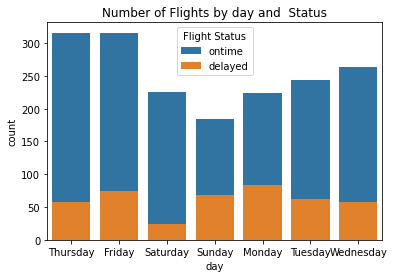

In [10]:
day = []
for row in data_exploration['DAY_WEEK']:
        if row == 1 :    day.append('Monday')
        elif row == 2:   day.append('Tuesday')
        elif row == 3:   day.append('Wednesday')
        elif row == 4:   day.append('Thursday')
        elif row == 5:   day.append('Friday')
        elif row == 6:   day.append('Saturday')
        else :           day.append('Sunday')
data_exploration['day']=day
data_exploration
pv1=data_exploration.groupby(['day'])['Flight Status'].value_counts()
pv1

ax = sns.countplot(x='day',data=data_exploration,hue='Flight Status',dodge=False)
ax.set_title('Number of Flights by day and  Status')

<BarContainer object of 3 artists>

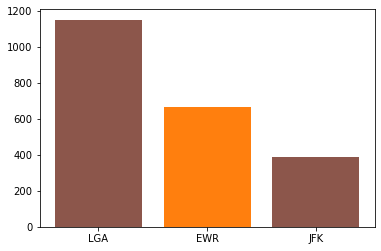

In [11]:
dest=data_exploration.DEST.value_counts()
fig,ax = plt.subplots()
ax.bar(dest.index, dest, color=['C5', 'C1'])

<BarContainer object of 3 artists>

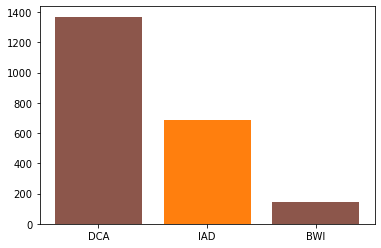

In [12]:
org = data_exploration.ORIGIN.value_counts()
fig,ax = plt.subplots()
ax.bar(org.index, org, color=['C5', 'C1'])

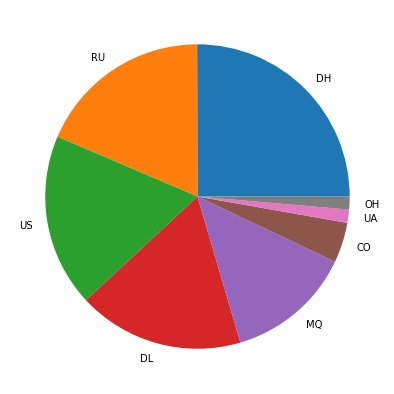

In [23]:
Car=data_exploration.CARRIER.value_counts()
fig = plt.figure(figsize =(10, 7))
plt.pie(Car, labels =['DH','RU','US','DL','MQ','CO','UA','OH'] )
plt.show()


In [24]:
stats = pd.pivot_table(train_df, values='DISTANCE', index=['ORIGIN','DEST'],
                    columns=['CARRIER'], aggfunc=np.mean, fill_value=0)

print(stats)

CARRIER       CO   DH   DL   MQ   OH   RU   UA   US
ORIGIN DEST                                        
BWI    EWR     0    0    0    0    0  169    0    0
       JFK     0    0    0    0  184    0    0    0
DCA    EWR   199    0    0    0    0  199    0    0
       JFK     0  213  213  213    0    0    0    0
       LGA     0    0  214  214    0    0    0  214
IAD    EWR     0  213    0    0    0  213    0    0
       JFK     0  228    0    0    0    0    0    0
       LGA     0  229    0    0    0    0  229    0


## Naive Bayes Classifier

In [25]:
logit_df=train_df.head()
logit_df

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


In [26]:
Predictors =['CRS_DEP_TIME', 'CARRIER','DEP_TIME','DEST','DAY_WEEK', 'DISTANCE','FL_NUM','ORIGIN']
outcome =['Flight Status']


In [27]:

x = pd.get_dummies(train_df[['CRS_DEP_TIME', 'CARRIER','DEP_TIME','DEST','DAY_WEEK', 'DISTANCE','FL_NUM','ORIGIN']])
y = train_df['Flight Status']


x.shape

(2201, 19)

In [28]:
tra_x,tes_x,tra_y,tes_y = train_test_split(x,y, test_size=0.4, random_state=1)


In [29]:
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(tra_x, tra_y)

MultinomialNB(alpha=0.01)

In [30]:
predProb_train = delays_nb.predict_proba(tra_x)

predProb_valid = delays_nb.predict_proba(tes_x)
predProb_valid

array([[1.00000000e+00, 4.74501499e-40],
       [9.06343850e-11, 1.00000000e+00],
       [1.00000000e+00, 6.24970910e-29],
       ...,
       [4.47190140e-31, 1.00000000e+00],
       [1.52869118e-07, 9.99999847e-01],
       [1.25657473e-33, 1.00000000e+00]])

In [31]:
y_valid_pred = delays_nb.predict(tes_x)
y_train_pred = delays_nb.predict(tra_x)


In [83]:
Nb=metrics.accuracy_score(tes_y, y_valid_pred)

Nb

0.5664018161180476

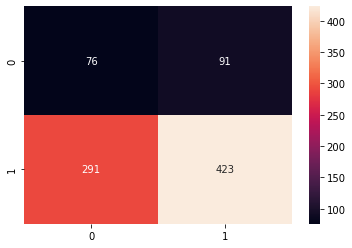

array([[ 76,  91],
       [291, 423]], dtype=int64)

In [33]:
cm = confusion_matrix(tes_y, y_valid_pred)
#sns.heatmap(cm, annot=True)

DetaFrame_cm = pd.DataFrame(cm, range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True,fmt='g')
plt.show()
cm

In [35]:
tes_X= pd.read_csv('FlightDelaysTesting.csv')

coloumn_names =['CRS_DEP_TIME','DEP_TIME','DAY_WEEK','DISTANCE','FL_NUM','CARRIER_CO','CARRIER_DH','CARRIER_DL','CARRIER_MQ','CARRIER_OH','CARRIER_RU','CARRIER_UA','CARRIER_US','DEST_EWR','DEST_JFK','DEST_LGA','ORIGIN_BWI','ORIGIN_DCA','ORIGIN_IAD']

tes_X = tes_X.reindex(columns = coloumn_names)  
tes_X=tes_X.fillna(0)

print(tes_X)
tes_X.shape

   CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE  FL_NUM  CARRIER_CO  CARRIER_DH  \
0            15      1455         3       184    5935         0.0         0.0   
1            16      1641         1       228    7810         0.0         0.0   
2             6       630         3       214    1740         0.0         0.0   
3             6       558         2       213    4760         0.0         0.0   
4            18      1828         3       214    1764         0.0         0.0   

   CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIER_US  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGI

(5, 19)

In [36]:
test_pred = delays_nb.predict(tes_X)
test_pred

array(['delayed', 'delayed', 'delayed', 'delayed', 'delayed'], dtype='<U7')

## CART  Analysis

In [37]:
train_df

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,2004-01-31,2761,DCA,0,6,31,N15555,ontime
2197,1700,RU,1653,EWR,213,2004-01-31,2497,IAD,0,6,31,N16976,ontime
2198,1600,RU,1558,EWR,199,2004-01-31,2361,DCA,0,6,31,N14902,ontime
2199,1359,RU,1403,EWR,199,2004-01-31,2216,DCA,0,6,31,N16961,ontime


In [51]:
x = pd.get_dummies(train_df[['CRS_DEP_TIME', 'CARRIER','DEP_TIME','DEST','DAY_WEEK', 'DISTANCE','ORIGIN']])
y = train_df[['Flight Status']]

tra_a,tes_a,tra_b,tes_b = train_test_split(x,y, test_size=0.4, random_state=1)
tra_a.shape

(1320, 18)

In [52]:
clf = DecisionTreeClassifier()

In [53]:
clf = clf.fit(tra_a,tra_b)

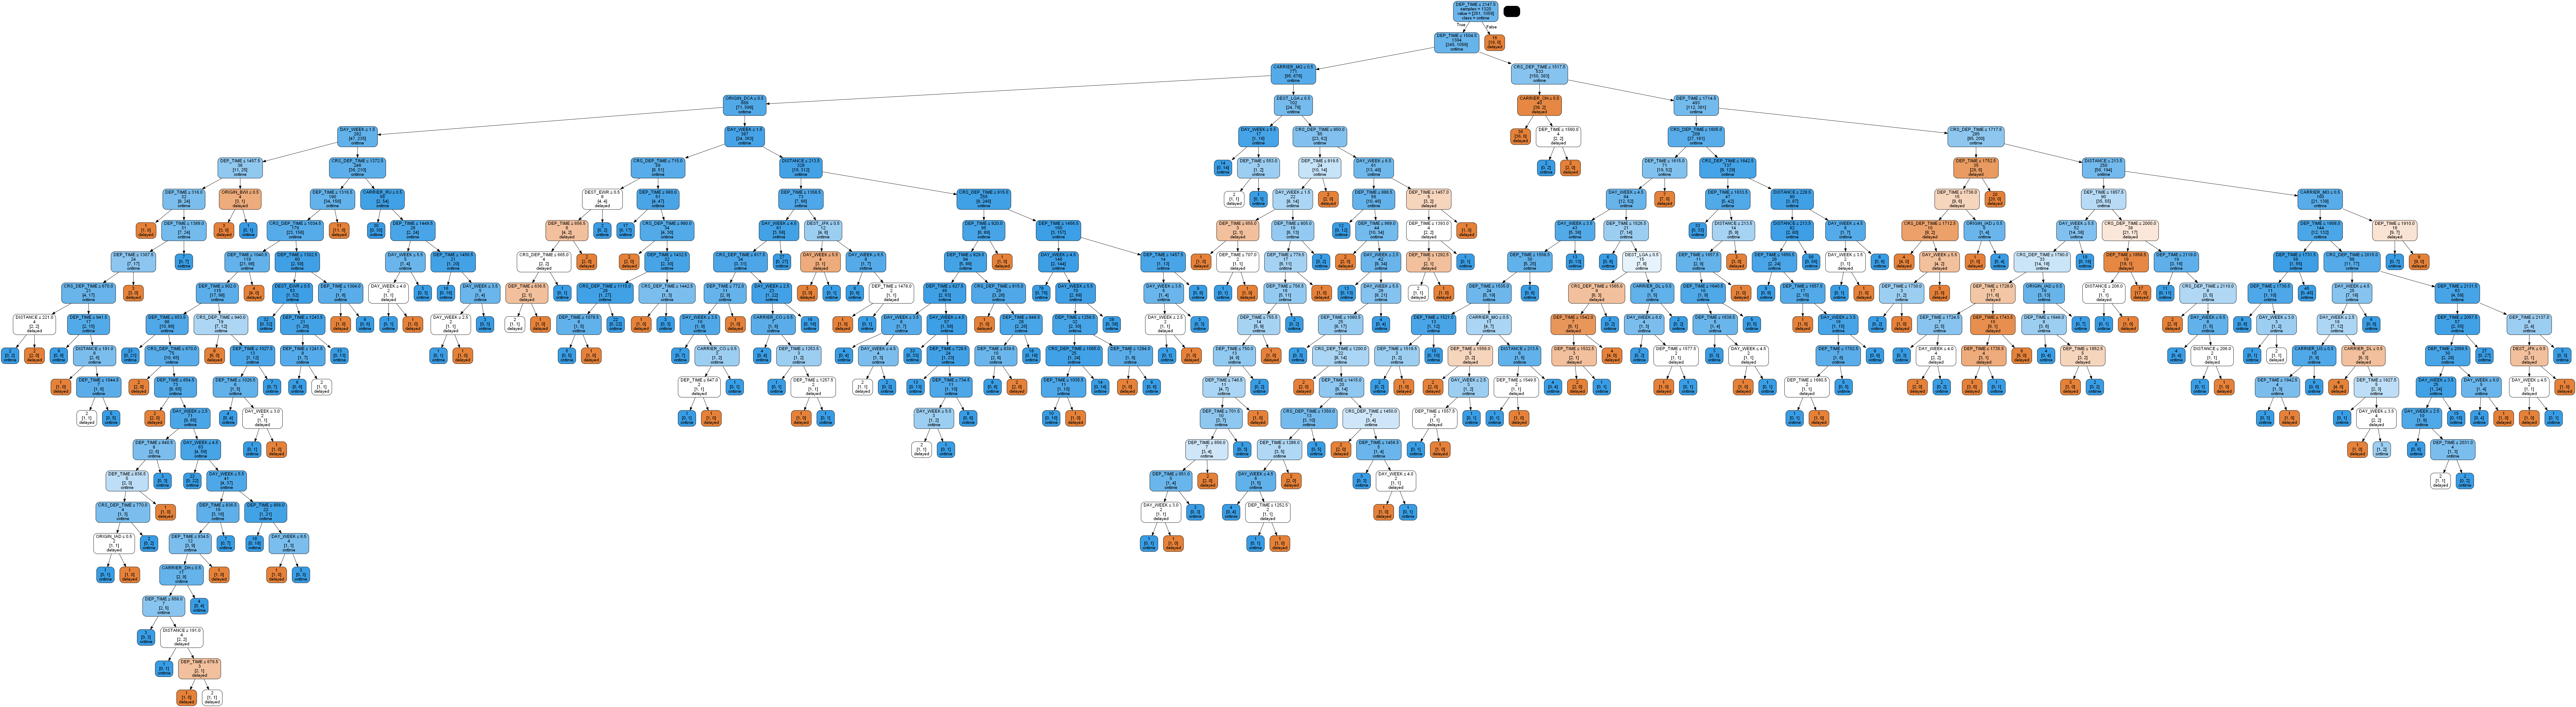

In [54]:
plotDecisionTree(clf, feature_names=x.columns, class_names=clf.classes_)

In [45]:
y_pred = clf.predict(tes_a)
y_pred

array(['ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'delayed', 'ontime', 'delayed', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'delayed', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'delayed', 'delayed',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'delayed',
       'ontime', 'delayed', 'ontime', 'ontime', 'delayed', 'ontime',
       'ontime', 'ontime', 'delayed', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'delayed', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'ontime', 'ontime', 'ontime',
       'ontime', 'ontime', 'ontime', 'delayed', 'ontime', 'ontime',
       'ontime', 'ontime', 'delayed', 'ontime', 'de

In [91]:
cart=metrics.accuracy_score(tes_b, y_pred)
cart

0.8342792281498297

In [47]:
test_five= pd.read_csv('FlightDelaysTesting.csv')

coloumn_names =['CRS_DEP_TIME','DEP_TIME','DAY_WEEK','DISTANCE','FL_NUM','CARRIER_CO','CARRIER_DH','CARRIER_DL','CARRIER_MQ','CARRIER_OH','CARRIER_RU','CARRIER_UA','CARRIER_US','DEST_EWR','DEST_JFK','DEST_LGA','ORIGIN_BWI','ORIGIN_DCA','ORIGIN_IAD']

test_five = test_five.reindex(columns = coloumn_names)  
test_five=test_five.fillna(0)

print(test_five)


   CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE  FL_NUM  CARRIER_CO  CARRIER_DH  \
0            15      1455         3       184    5935         0.0         0.0   
1            16      1641         1       228    7810         0.0         0.0   
2             6       630         3       214    1740         0.0         0.0   
3             6       558         2       213    4760         0.0         0.0   
4            18      1828         3       214    1764         0.0         0.0   

   CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIER_US  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGI

In [48]:
y_pred2 = clf.predict(test_five)

In [49]:
y_pred2

array(['delayed', 'delayed', 'ontime', 'ontime', 'delayed'], dtype=object)

## Logistic regression

In [59]:
flights_df =train_df

In [60]:
flights_df.drop(columns=['FL_DATE','DAY_OF_MONTH','TAIL_NUM'], inplace=True)
flights_df.columns = [c.replace(' ', '_') for c in flights_df.columns]

In [61]:
flights_df['Flight_Status'] = flights_df['Flight_Status'].astype('category')
new_categories = {'ontime': '1', 'delayed': '0'}
flights_df.Flight_Status.cat.rename_categories(new_categories, inplace=True)
flights_df = pd.get_dummies(flights_df, prefix_sep='_', drop_first=True)
flights_df.head()

C:\Users\mazah\anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_JFK,DEST_LGA,ORIGIN_DCA,ORIGIN_IAD,Flight_Status_1
0,1455,1455,184,5935,0,4,0,0,0,1,0,0,0,1,0,0,0,1
1,1640,1640,213,6155,0,4,1,0,0,0,0,0,0,1,0,1,0,1
2,1245,1245,229,7208,0,4,1,0,0,0,0,0,0,0,1,0,1,1
3,1715,1709,229,7215,0,4,1,0,0,0,0,0,0,0,1,0,1,1
4,1039,1035,229,7792,0,4,1,0,0,0,0,0,0,0,1,0,1,1


In [62]:
flights_df.head()

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_JFK,DEST_LGA,ORIGIN_DCA,ORIGIN_IAD,Flight_Status_1
0,1455,1455,184,5935,0,4,0,0,0,1,0,0,0,1,0,0,0,1
1,1640,1640,213,6155,0,4,1,0,0,0,0,0,0,1,0,1,0,1
2,1245,1245,229,7208,0,4,1,0,0,0,0,0,0,0,1,0,1,1
3,1715,1709,229,7215,0,4,1,0,0,0,0,0,0,0,1,0,1,1
4,1039,1035,229,7792,0,4,1,0,0,0,0,0,0,0,1,0,1,1


In [63]:
y = flights_df['Flight_Status_1']
X = flights_df.drop(columns=['Flight_Status_1'])

In [64]:
train_a, valid_a, train_b, valid_b = train_test_split(x, y, test_size=0.4, random_state=1)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_a, train_b)
train_a.shape

(1320, 18)

In [65]:
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=x.columns).transpose())
print()

intercept  0.06553965355908076
       CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE  CARRIER_CO  CARRIER_DH  \
coeff      0.032931 -0.033358  0.072986  0.009093   -0.203817    0.309405   

       CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIER_US  \
coeff    0.862051   -1.174537     0.26374   -0.005404    0.076333   -0.062231   

       DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  ORIGIN_IAD  
coeff -0.109213  0.112508  0.062245    0.417726   -0.098343   -0.253844  



In [66]:
logit_reg_pred = logit_reg.predict(valid_a)
logit_reg_proba = logit_reg.predict_proba(valid_a)
logit_result = pd.DataFrame({'actual': valid_b,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })
print(logit_result)

      actual      p(0)      p(1)  predicted
1276       1  0.140596  0.859404          1
1446       1  0.058019  0.941981          1
335        1  0.105963  0.894037          1
1458       1  0.087774  0.912226          1
2038       1  0.055359  0.944641          1
...      ...       ...       ...        ...
460        1  0.221590  0.778410          1
2063       1  0.060765  0.939235          1
159        1  0.250880  0.749120          1
2027       0  0.034211  0.965789          1
1247       1  0.043552  0.956448          1

[881 rows x 4 columns]


In [67]:
interestingCases = [1276,335,460,1458,2027]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
1276       1  0.140596  0.859404          1
335        1  0.105963  0.894037          1
460        1  0.221590  0.778410          1
1458       1  0.087774  0.912226          1
2027       0  0.034211  0.965789          1


In [68]:
classificationSummary(train_b, logit_reg.predict(train_a))

Confusion Matrix (Accuracy 0.9015)

       Prediction
Actual    0    1
     0  144  117
     1   13 1046


In [89]:
log = metrics.accuracy_score(valid_b,logit_reg.predict(valid_a) )
log

0.8989784335981839

Confusion Matrix (Accuracy 0.9001)

       Prediction
Actual   0   1
     0  91  76
     1  12 702


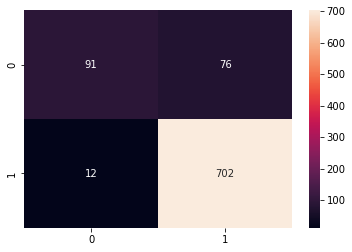

In [81]:
classificationSummary(valid_b, logit_reg.predict(valid_a))
cm = confusion_matrix(valid_b, logit_reg_pred)
DetaFrame_cm = pd.DataFrame(cm, range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True,fmt='g')
plt.show()



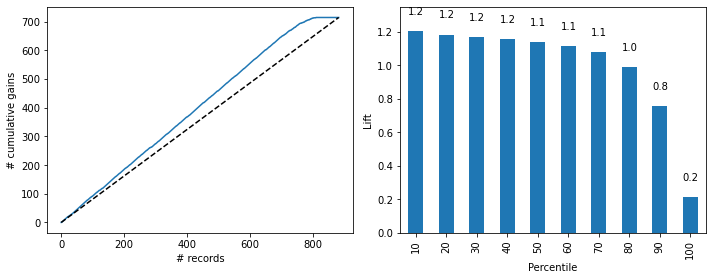

In [44]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [148]:
test = pd.read_csv('FlightDelaysTesting.csv')
test.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM
0,15,OH,1455,JFK,184,1/7/2004,5935,BWI,0,3,7,N983CA
1,16,DH,1641,JFK,228,1/19/2004,7810,IAD,0,1,19,N327UE
2,6,DL,630,LGA,214,1/21/2004,1740,DCA,0,3,21,N242DL
3,6,MQ,558,JFK,213,1/6/2004,4760,DCA,0,2,6,N739MQ
4,18,DL,1828,LGA,214,1/21/2004,1764,DCA,0,3,21,N242DL


In [149]:
test.drop(columns=['FL_DATE','DAY_WEEK','DAY_OF_MONTH','TAIL_NUM'], inplace=True)
test.columns = [c.replace(' ', '_') for c in test.columns]

In [150]:
coloumn_names =['CRS_DEP_TIME','DEP_TIME','DAY_WEEK','DISTANCE','FL_NUM','Weather','CARRIER_CO','CARRIER_DH','CARRIER_DL','CARRIER_MQ','CARRIER_OH','CARRIER_RU','CARRIER_UA','CARRIER_US','DEST_EWR','DEST_JFK','DEST_LGA','ORIGIN_BWI','ORIGIN_DCA','ORIGIN_IAD']
test = test.reindex(columns = coloumn_names)
a=test.fillna(0)
print(a)
a.shape

   CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE  FL_NUM  Weather  CARRIER_CO  \
0            15      1455       0.0       184    5935        0         0.0   
1            16      1641       0.0       228    7810        0         0.0   
2             6       630       0.0       214    1740        0         0.0   
3             6       558       0.0       213    4760        0         0.0   
4            18      1828       0.0       214    1764        0         0.0   

   CARRIER_DH  CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   CARRIER_US  DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA 

(5, 20)

In [152]:
logit_reg_pred = logit_reg.predict(a)
logit_reg_pred

array([0, 0, 0, 0, 0], dtype=uint8)

## Conclusion


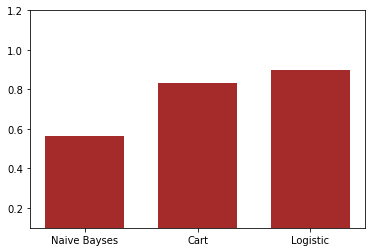

In [99]:
x_label=['Naive Bayses','Cart','Logistic']
y_label=[0.5664018161180476,0.8342792281498297,0.8989784335981839]
plt.bar(x_label,y_label, color ='Brown',width = 0.7)
low = min(y_label)
high = max(y_label)
plt.ylim(0.1,1.2)
plt.show()